In [143]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import FTestAnovaPower
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import dill
import pingouin as pg
import data_visualization as dv
import analysis_utilities as au
from analysis_utilities import Bootstrap
import importlib

# Initial Thangs

In [144]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Boostrap Function

In [145]:
def bootstrap(metric,plot=True):
    if mean:
        mdt_1000  = np.concatenate((metric[:,0],metric[:,1]))
        mdt_1100  = np.concatenate((metric[:,2],metric[:,3]))
        mdt_1200  = np.concatenate((metric[:,4],metric[:,5]))
    if sd:
        data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
        data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))


    # Mean differences original
    diff_a = mdt_1000 - mdt_1100
    diff_b = mdt_1000 - mdt_1200
    diff_c = mdt_1100 - mdt_1200
    mean_diffa, mean_diffb, mean_diffc = np.mean(diff_a),np.mean(diff_b),np.mean(diff_c)

    # Mean differences normalized around 0
    diff0 = diff_a - mean_diffa
    diff1 = diff_b - mean_diffb
    diff2 = diff_c - mean_diffc
    mean_diff0,mean_diff1,mean_diff2 = np.mean(diff0),np.mean(diff1),np.mean(diff1)
    mean_diff_list = [mean_diff0,mean_diff1,mean_diff2]
    boot_m = 10000
    boot_diff_matrix = np.empty((3,boot_m))
    for i in range(boot_m):
        data_boot0 = np.random.choice(diff0,size=len(diff0),replace=True)
        data_boot1 = np.random.choice(diff1,size=len(diff1),replace=True)
        data_boot2 = np.random.choice(diff2,size=len(diff2),replace=True)
        boot_diff_matrix[0,i] = np.mean(data_boot0)
        boot_diff_matrix[1,i] = np.mean(data_boot1)
        boot_diff_matrix[2,i] = np.mean(data_boot2)
    c_arr = np.array([0,0,0])
    original_mean_diffs = [abs(mean_diffa),abs(mean_diffb),abs(mean_diffc)]
    # How many times did we get a test statsitic from the bootstrap that was larger (smaller) than the original mean diff (or neg mean diff)
    for i in range(3):
        for j in range(boot_m):
            if boot_diff_matrix[i,j]<original_mean_diffs[i]*-1:
                c_arr[i]+=1
            if boot_diff_matrix[i,j]>original_mean_diffs[i]:
                c_arr[i]+=1
    pvals = np.array(c_arr)/boot_m
    print(pvals)


    conf_up0 = np.quantile(boot_diff_matrix[0],0.975)
    conf_down0 = np.quantile(boot_diff_matrix[0],0.025)
    conf_up1 = np.quantile(boot_diff_matrix[1],0.975)
    conf_down1 = np.quantile(boot_diff_matrix[1],0.025)
    conf_up2 = np.quantile(boot_diff_matrix[2],.975)
    conf_down2 = np.quantile(boot_diff_matrix[2],0.025)

    conf_ups = [conf_up0,conf_up1,conf_up2]
    conf_downs = [conf_down0,conf_down1,conf_down2]
    
    if plot:
        titles = ['Mean Difference 1000 - 1100','Mean Difference 1000 - 1200','Mean Difference 1100 - 1200']
        i=-1
        for ciu,cid in zip(conf_ups,conf_downs):
            i+=1
            fig,ax = plt.subplots(dpi=125,figsize=(8,4))
            ax.hist(boot_diff_matrix[i],bins=50,color=wheel.dark_grey,zorder=0)
            ax.axvline(original_mean_diffs[i],c=wheel.rak_orange)
            ax.axvline(-original_mean_diffs[i],c=wheel.rak_orange)
            # ax.axvline(ciu,c=wheel.rak_red)
            # ax.axvline(cid,c=wheel.rak_red)
            ax.axvline(np.median(boot_diff_matrix[i]),c=wheel.rak_blue)
            ax.set_ylabel('Counts')
            ax.set_xlabel('Bootstrapped Median\nDecision Time Difference (ms)')
            ax.set_title(titles[i])
            ax.text(-original_mean_diffs[i],500,f'P={pvals[i]}')
            dv.Custom_Legend(ax,['Mean Differences','Bootstrapped Median'],[wheel.rak_orange,wheel.rak_blue])


# Pickle

In [146]:
NUM_STDS = 2
append_dict = {0:'reaction_time_no_sd_off',1:'reaction_time_minus_sd',2:'reaction_time_minus_2sd'}
load_path = r'D:\Subject_Data\Seth_MatchPennies_Agent_Exp1\Subjects_Analyzed\\'
subject = dill.load((open(load_path + f'subject_object_{append_dict[NUM_STDS]}_dict.pkl', 'rb')))
group   = dill.load((open(load_path + f'group_object_{append_dict[NUM_STDS]}.pkl', 'rb')))
group.analyze_data()
num_subjects = len(subject.keys())

c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:471: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_wins_mean                      = np.nanmean(self.combine_all_subjects('perc_binned_player_wins'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:472: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_indecisions_mean               = np.nanmean(self.combine_all_subjects('perc_binned_player_indecisions'),axis = 0)
c:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:473: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_incorrects_mean                = np.nanmean(self.combine_all_subjects('perc_binned_player_incorrects'),axis

# Power Analysis

In [147]:
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=0.5,power=0.8,alpha=0.05)


In [148]:
analysis = FTestAnovaPower()
sample_size = analysis.solve_power(effect_size=0.5,nobs=None,alpha=0.05,power=0.8,k_groups=6)
sample_size

57.10661888657371

# Create DataFrame for Pingouin

In [149]:
wins = group.combine_all_subjects('player_perc_wins').flatten().tolist()
indecisions = group.combine_all_subjects('player_perc_indecisions').flatten().tolist()
incorrects = group.combine_all_subjects('player_perc_incorrects').flatten().tolist()
leave_times = group.combine_all_subjects('player_task_leave_time_median').flatten().tolist()
leave_time_sd = group.combine_all_subjects('player_task_leave_time_sd').flatten().tolist()
gamble_leave_time = group.combine_all_subjects('player_gamble_leave_time_median').flatten().tolist()
subject_number = np.repeat(np.arange(1,21,1,dtype=int),6).tolist()
alt_condition = np.tile(['1000 (50)','1000 (150)','1100 (50)','1100 (150)', '1200 (50)', '1200 (150)'],num_subjects).tolist()
condition_mean = np.tile(['1000','1000','1100','1100','1200','1200'],num_subjects)
condition_sd = np.tile(['50','150'],num_subjects*3)
condition = np.tile(np.arange(1,7,1,dtype=int),num_subjects).tolist()
df = pd.DataFrame(np.array([subject_number,condition,condition_mean,condition_sd,leave_times,wins,indecisions,incorrects,
                            gamble_leave_time,leave_time_sd]).T,
                  columns=['Subject','Condition','Condition Mean','Condition SD','Median Leave Time','Wins','Indecisions','Incorrects',
                           'Median Gamble Leave Time','SD Leave Time'])
df = df.astype('float64')
df = df.astype({'Subject':'int32','Condition':'int32','Condition Mean':'int32','Condition SD':'int32'})
df

,Subject,Condition,Condition Mean,Condition SD,Median Leave Time,Wins,Indecisions,Incorrects,Median Gamble Leave Time,SD Leave Time
0,1,1,1000,50,1197.5,58.75,3.75,37.50,1137.0,96.397494
1,1,2,1000,150,1211.5,70.00,17.50,12.50,1206.5,110.066262
2,1,3,1100,50,1268.0,53.75,16.25,30.00,1183.5,148.082229
3,1,4,1100,150,1166.0,53.75,5.00,41.25,1156.0,117.245975
4,1,5,1200,50,1165.5,42.50,3.75,53.75,1165.0,133.403615
...,...,...,...,...,...,...,...,...,...,...
115,20,2,1000,150,970.0,50.00,8.75,41.25,946.5,192.284624
116,20,3,1100,50,1089.0,47.50,13.75,38.75,1040.0,152.755777
117,20,4,1100,150,1059.0,51.25,13.75,35.00,999.5,192.834054
118,20,5,1200,50,1053.5,43.75,8.75,47.50,1048.5,179.781950


# Run Anova and Bootstrap T-tests

## Task Leave Time Median

#### RM Anova

In [150]:
pg.rm_anova(data=df, dv='Median Leave Time', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,58937.112500,2,38,29468.556250,4.529204,0.017210,0.026786,0.032825,0.777894
1,Condition SD,65030.352083,1,19,65030.352083,6.832218,0.017073,0.017073,0.036096,1.000000
2,Condition Mean * Condition SD,2199.329167,2,38,1099.664583,0.431413,0.652732,0.615635,0.001265,0.826455


#### Follow-up Mean Comparisons

Bootstrap Median Leave Time Comparisons Collapse Across Means

In [151]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))
print(f'Compare 1000 to 1100: Pval = {au.Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {au.Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {au.Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0044
Compare 1100 to 1200: Pval = 0.0057
Compare 1000 to 1200: Pval = 0.5168


[0.0059 0.529  0.0074]


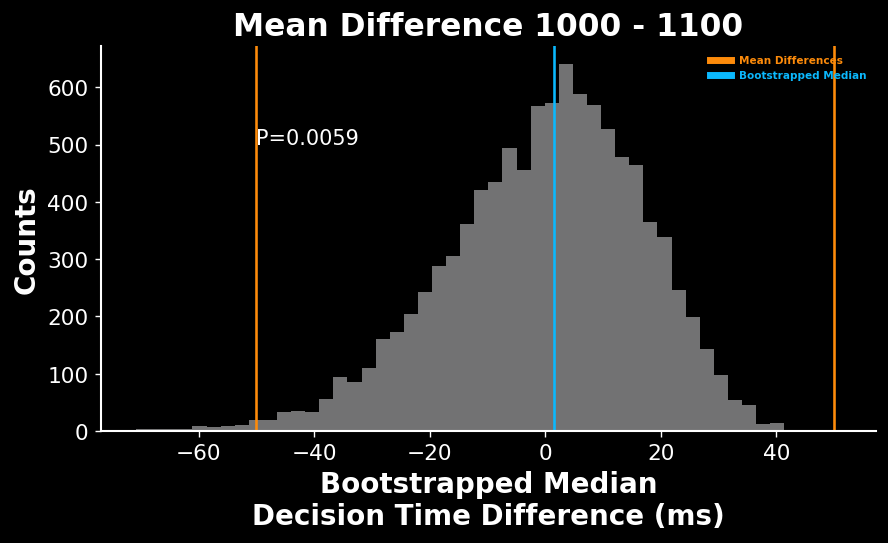

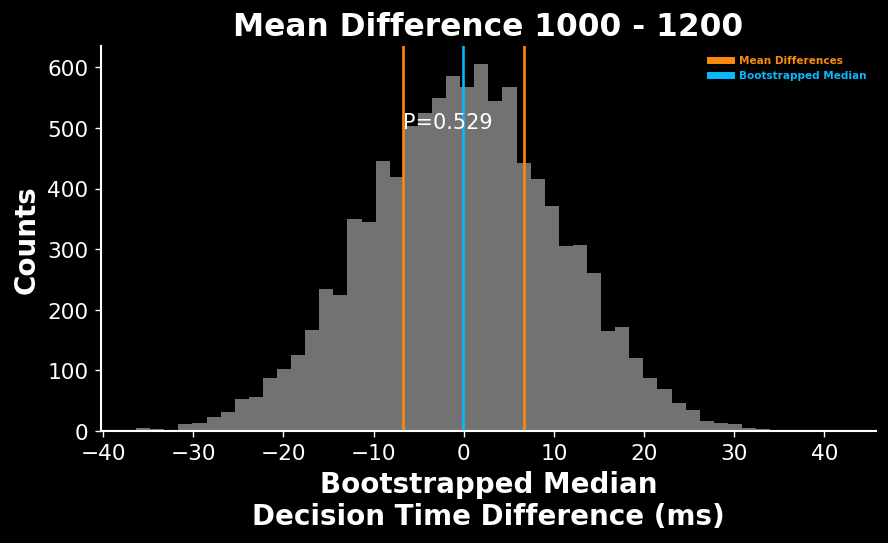

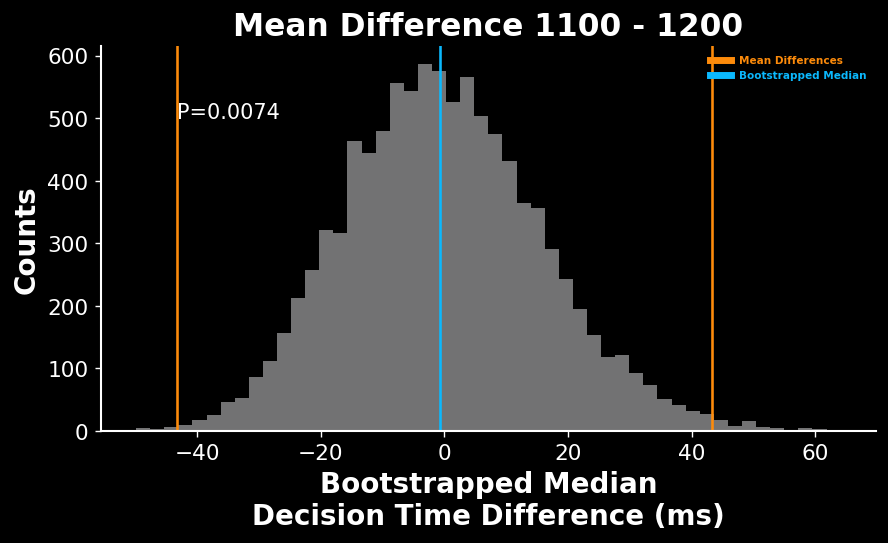

In [152]:
metric = group.combine_all_subjects('player_task_leave_time_median')
bootstrap(metric)
    

Bootstrap Median Leave Time Comparisons Collapse Across SDs

In [179]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(au.Bootstrap(data1,data2,paired=True,return_distribution=True))

(0.0006, array([-12.09252333,  15.97414333,  -8.95919   , ...,  16.62414333,
        -8.14252333,   6.65747667]))


## Task Decision Time SD

#### RM Anova

In [154]:
pg.rm_anova(data=df, dv='SD Leave Time', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,11011.380479,2,38,5505.690239,4.042899,0.025593,0.047486,0.036399,0.629181
1,Condition SD,13738.555996,1,19,13738.555996,18.442220,0.000391,0.000391,0.045008,1.000000
2,Condition Mean * Condition SD,5478.084231,2,38,2739.042115,3.372111,0.044863,0.047819,0.018446,0.947671


#### Follow-up Mean Comparisons

Bootstrap Median Leave Time Comparisons Collapse Across Means

In [176]:
metric    = group.combine_all_subjects('player_task_leave_time_sd')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))
print(f'Compare 1000 to 1100: Pval = {au.Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {au.Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {au.Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.5162
Compare 1100 to 1200: Pval = 0.0495
Compare 1000 to 1200: Pval = 0.0


[0.5231 0.     0.0513]


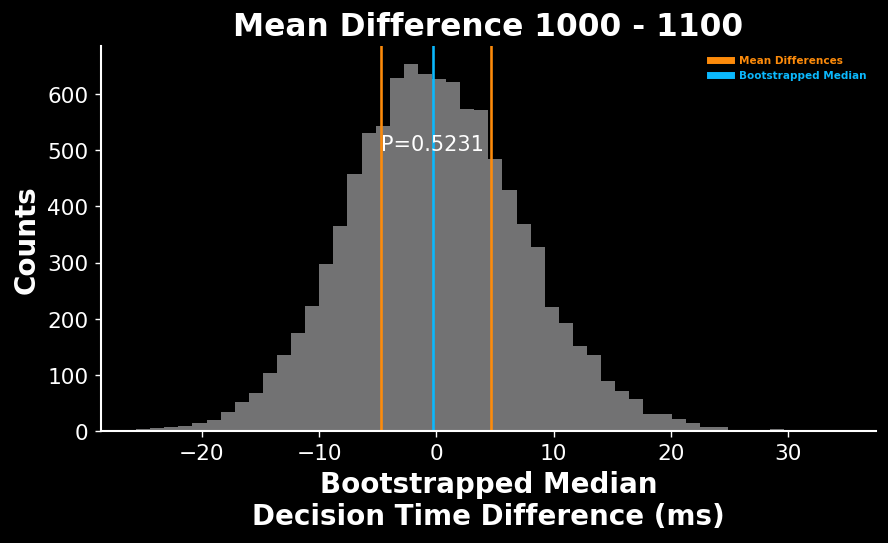

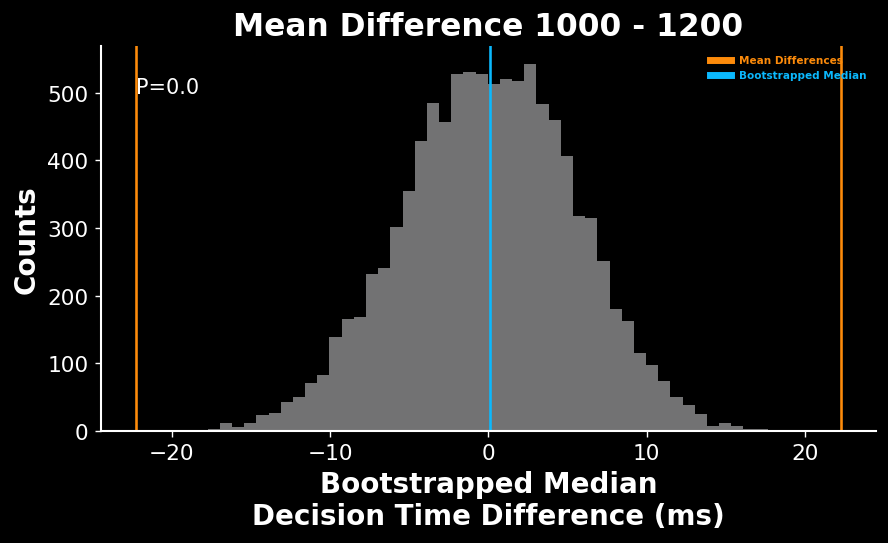

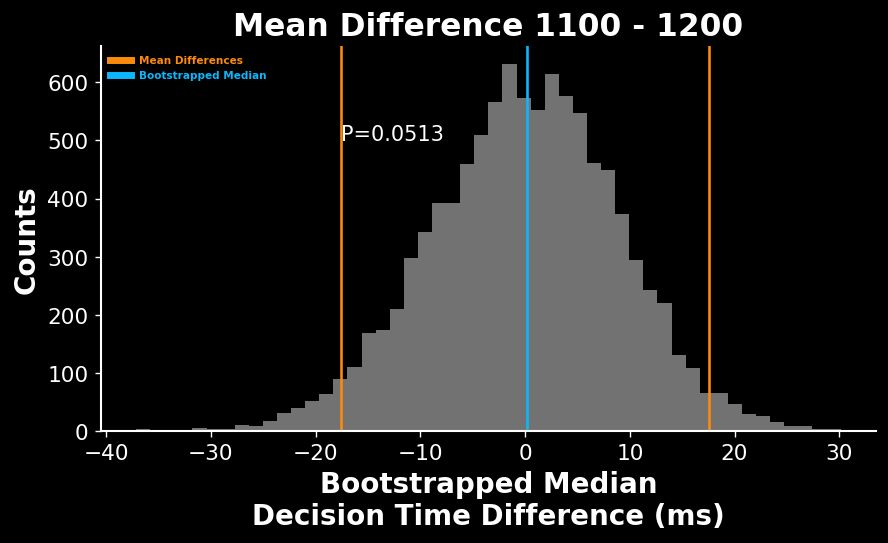

In [177]:
metric = group.combine_all_subjects('player_task_leave_time_sd')
bootstrap(metric)

Bootstrap Median Leave Time Comparisons Collapse Across SDs

In [178]:
metric    = group.combine_all_subjects('player_task_leave_time_sd')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(au.Bootstrap(data1,data2,paired=True,return_distribution=True))

(0.0001, array([ 5.0503575 , -1.29851837, -5.73263739, ...,  2.31868216,
       -3.75894033, -1.39504936]))


## Task Gamble Decision Time Median

#### RM Anova

In [158]:
pg.rm_anova(data=df, dv='Median Gamble Leave Time', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,107427.712500,2,38,53713.856250,5.005913,0.011756,0.018734,0.046393,0.798243
1,Condition SD,106.408333,1,19,106.408333,0.008148,0.929020,0.929020,0.000048,1.000000
2,Condition Mean * Condition SD,58719.704167,2,38,29359.852083,3.883396,0.029203,0.051707,0.025903,0.633650


#### Follow-up Mean Comparisons

Bootstrap Median Leave Time Comparisons Collapse Across Means

In [159]:
metric    = group.combine_all_subjects('player_gamble_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))
print(f'Compare 1000 to 1100: Pval = {au.Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {au.Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {au.Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0067
Compare 1100 to 1200: Pval = 0.2328
Compare 1000 to 1200: Pval = 0.0327


[0.006  0.0348 0.2292]


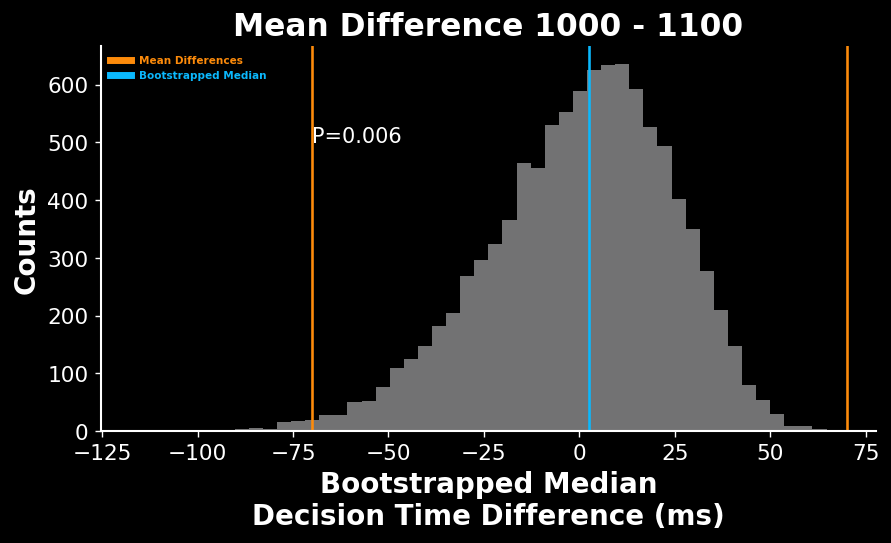

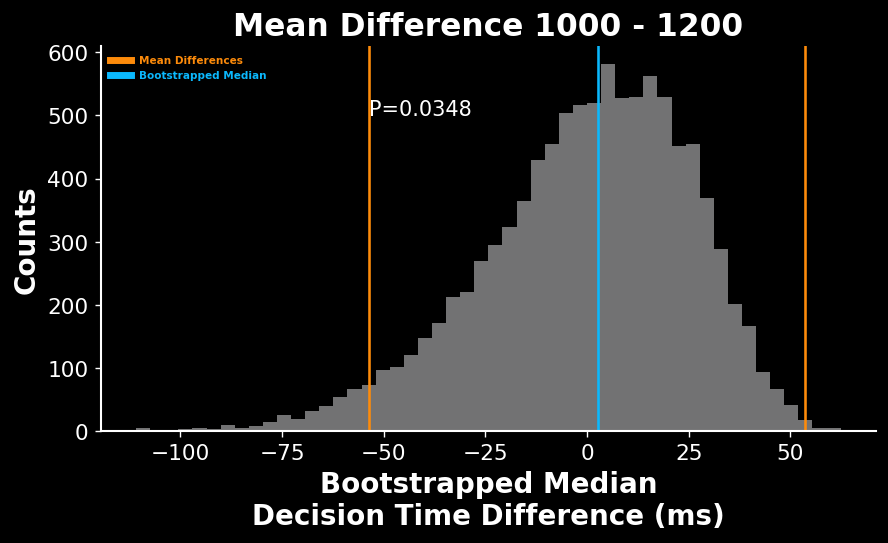

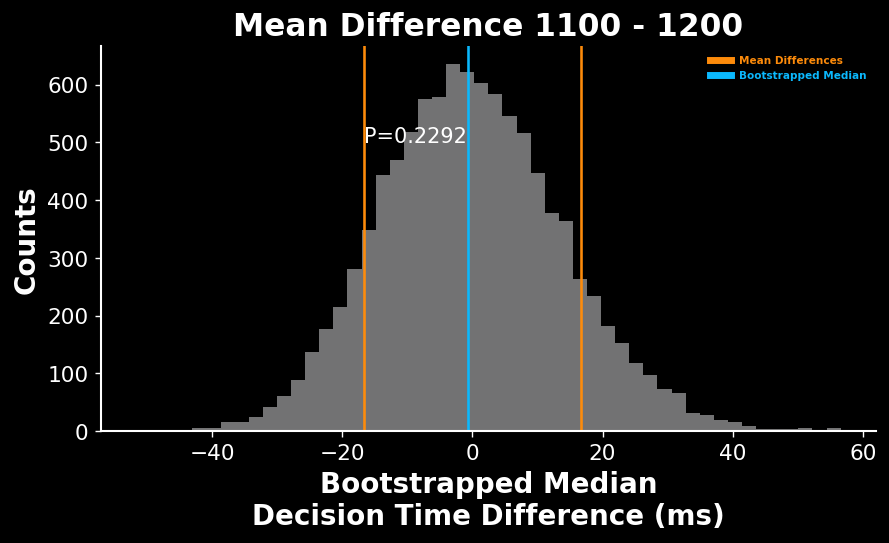

In [160]:
metric = group.combine_all_subjects('player_gamble_leave_time_median')
bootstrap(metric)

Bootstrap Median Leave Time Comparisons Collapse Across SDs

In [161]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(au.Bootstrap(data1,data2,paired=True,return_distribution=True))

(0.0008, array([20.78221667, -4.07611667, 12.54888333, ..., 11.04055   ,
       13.34055   ,  0.60721667]))


## Task Gamble Decision Time SD

#### RM Anova

In [162]:
pg.rm_anova(data=df, dv='Median Gamble Leave Time', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,107427.712500,2,38,53713.856250,5.005913,0.011756,0.018734,0.046393,0.798243
1,Condition SD,106.408333,1,19,106.408333,0.008148,0.929020,0.929020,0.000048,1.000000
2,Condition Mean * Condition SD,58719.704167,2,38,29359.852083,3.883396,0.029203,0.051707,0.025903,0.633650


#### Follow-up Mean Comparisons

Bootstrap Median Leave Time Comparisons Collapse Across Means

In [163]:
metric    = group.combine_all_subjects('player_gamble_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))
print(f'Compare 1000 to 1100: Pval = {au.Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {au.Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {au.Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0064
Compare 1100 to 1200: Pval = 0.2378
Compare 1000 to 1200: Pval = 0.0326


[0.0064 0.0302 0.233 ]


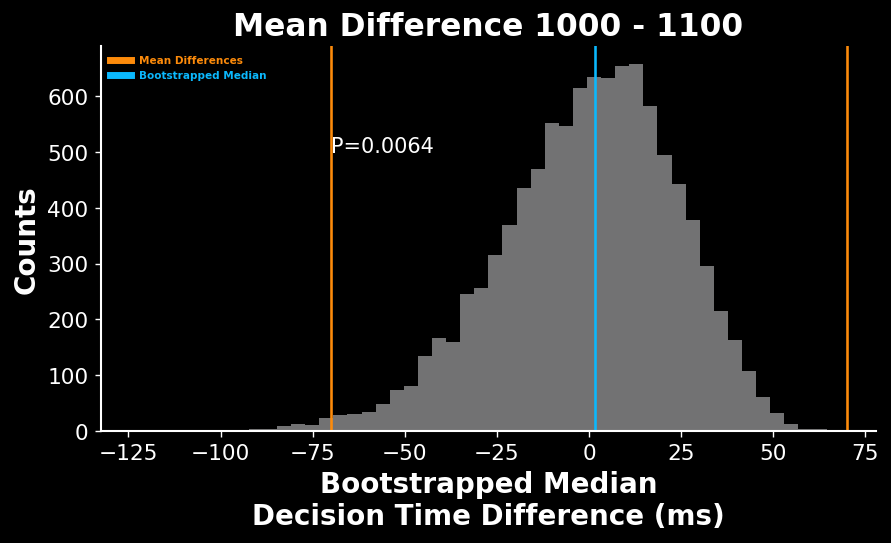

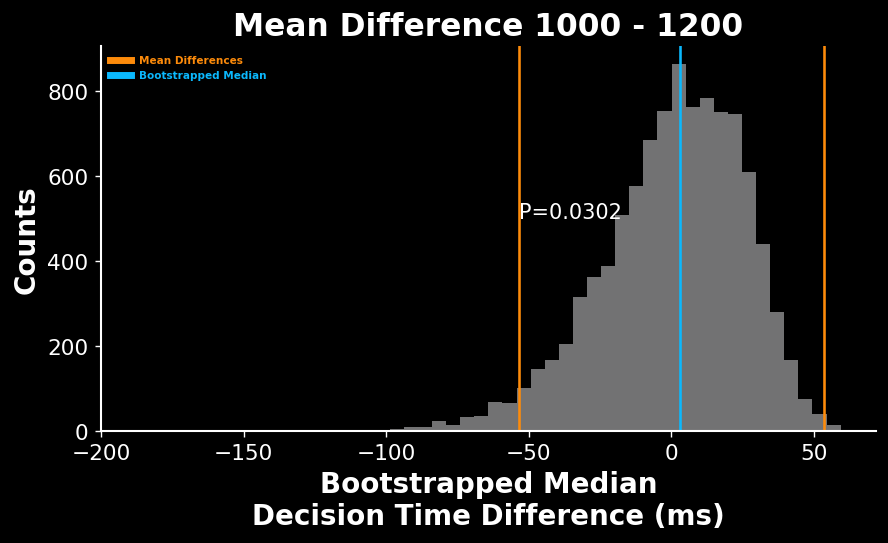

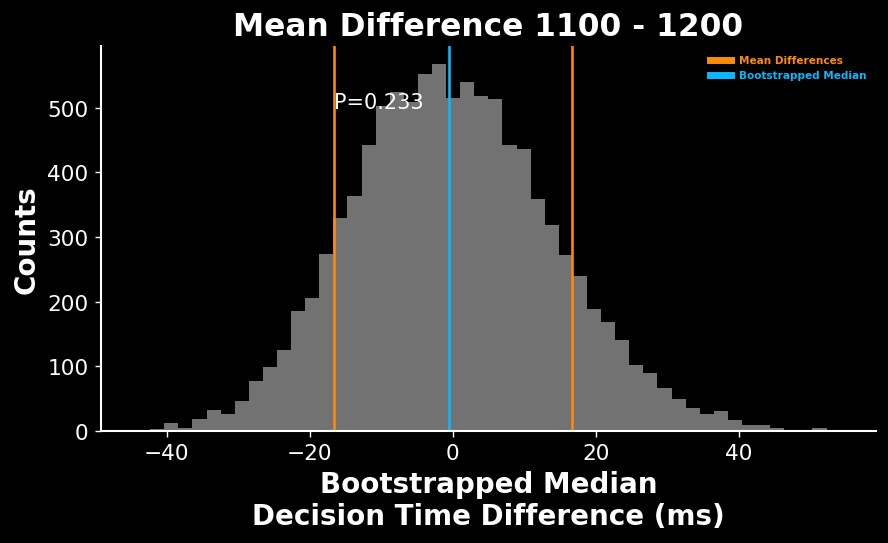

In [164]:
metric = group.combine_all_subjects('player_gamble_leave_time_median')
bootstrap(metric)

Bootstrap Median Leave Time Comparisons Collapse Across SDs

In [165]:
metric    = group.combine_all_subjects('player_task_leave_time_median')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(au.Bootstrap(data1,data2,paired=True,return_distribution=True))

(0.0003, array([-2.22130333, -7.18797   , -2.61297   , ..., -8.47130333,
       23.22036333, -2.12130333]))


## Wins

#### Anova

In [166]:
pg.rm_anova(data=df, dv='Wins', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,13373.671875,2,38,6686.835938,51.777019,1.407231e-11,2.670757e-09,0.501585,0.759118
1,Condition SD,579.700521,1,19,579.700521,8.951407,7.495068e-03,7.495068e-03,0.041799,1.000000
2,Condition Mean * Condition SD,2636.119792,2,38,1318.059896,23.729079,2.053863e-07,3.546155e-06,0.165531,0.770944


#### Bootstrap ttests

Collapse across sds

In [167]:
metric    = group.combine_all_subjects('player_perc_wins')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))

print(f'Compare 1000 to 1100: Pval = {Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0
Compare 1100 to 1200: Pval = 0.0
Compare 1000 to 1200: Pval = 0.0


Collapse across means

In [168]:
metric    = group.combine_all_subjects('player_perc_wins')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(f'Compare 50 to 150: Pval = {Bootstrap(data1,data2,paired=True)}')

Compare 50 to 150: Pval = 0.0143


## Indecisions

In [169]:
pg.rm_anova(data=df, dv='Indecisions', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,2502.838542,2,38,1251.419271,10.230605,0.000279,0.000455,0.111989,0.912708
1,Condition SD,138.138021,1,19,138.138021,1.029206,0.323091,0.323091,0.006912,1.000000
2,Condition Mean * Condition SD,1226.276042,2,38,613.138021,5.599133,0.007393,0.012819,0.058193,0.796413


Compare Means

In [170]:
metric    = group.combine_all_subjects('player_perc_indecisions')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))

print(f'Compare 1000 to 1100: Pval = {Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0001
Compare 1100 to 1200: Pval = 0.3805
Compare 1000 to 1200: Pval = 0.0017


In [ ]:
metric    = group.combine_all_subjects('player_perc_indecisions')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))

print(f'Compare 1000 to 1100: Pval = {Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {Bootstrap(data1,data3,paired=True)}')

Compare SDs (Not significant from anova)

In [171]:
metric    = group.combine_all_subjects('player_perc_wins')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(f'Compare 50 to 150: Pval = {Bootstrap(data1,data2,paired=True)}')

Compare 50 to 150: Pval = 0.0154


## Incorrects

Anova

In [172]:
pg.rm_anova(data=df, dv='Incorrects', within=['Condition Mean','Condition SD'], subject='Subject', detailed=True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition Mean,5961.354167,2,38,2980.677083,29.732602,1.689452e-08,1.472497e-07,0.246094,0.854052
1,Condition SD,151.875000,1,19,151.875000,2.377446,1.395897e-01,1.395897e-01,0.008248,1.000000
2,Condition Mean * Condition SD,564.687500,2,38,282.343750,3.730631,3.316652e-02,4.184158e-02,0.029993,0.840582


Compare Means

In [173]:
metric    = group.combine_all_subjects('player_perc_incorrects')
data1 = np.concatenate((metric[:,0],metric[:,1]))
data2 = np.concatenate((metric[:,2],metric[:,3]))
data3 = np.concatenate((metric[:,4],metric[:,5]))

print(f'Compare 1000 to 1100: Pval = {Bootstrap(data1,data2,paired=True)}')
print(f'Compare 1100 to 1200: Pval = {Bootstrap(data2,data3,paired=True)}')
print(f'Compare 1000 to 1200: Pval = {Bootstrap(data1,data3,paired=True)}')

Compare 1000 to 1100: Pval = 0.0077
Compare 1100 to 1200: Pval = 0.0
Compare 1000 to 1200: Pval = 0.0


Compare SDs (Not significant from anova)

In [174]:
metric    = group.combine_all_subjects('player_perc_incorrects')
data1 = np.concatenate((metric[:,0],metric[:,2],metric[:,4]))
data2 = np.concatenate((metric[:,1],metric[:,3],metric[:,5]))
print(f'Compare 50 to 150: Pval = {Bootstrap(data1,data2,paired=True)}')

Compare 50 to 150: Pval = 0.1584
